C:\Users\akhil\miniconda3\envs\openmm-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset loaded! Shape: (999, 15)


22:06:44 - cmdstanpy - INFO - Chain [1] start processing
22:06:44 - cmdstanpy - INFO - Chain [1] done processing


Resampled training class distribution:
CSAT_High
0    511
1    511
Name: count, dtype: int64


C:\Users\akhil\miniconda3\envs\openmm-env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:

              precision    recall  f1-score   support

           0       0.33      0.31      0.32        72
           1       0.62      0.65      0.64       128

    accuracy                           0.53       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.52      0.53      0.52       200

Confusion Matrix:

[[22 50]
 [45 83]]
ROC-AUC Score: 0.4947


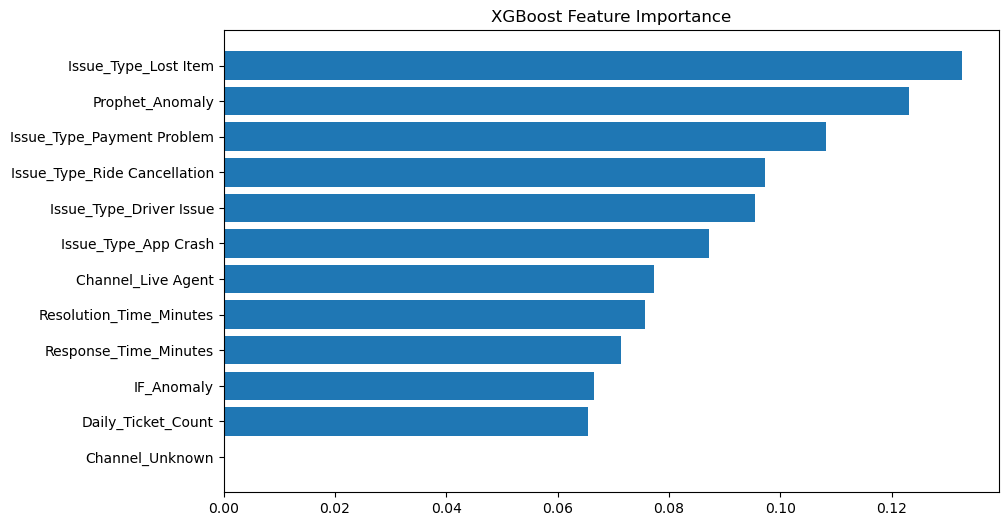

In [1]:
# -----------------------------
# Step 0: Install dependencies if missing
# -----------------------------
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Core libraries
for pkg in ["pandas", "scikit-learn", "xgboost", "prophet", "imbalanced-learn", "matplotlib"]:
    try:
        __import__(pkg)
    except ImportError:
        install(pkg)

# -----------------------------
# Step 1: Import libraries
# -----------------------------
import pandas as pd
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------------
# Step 2: Load dataset
# -----------------------------
df = pd.read_csv("Uber_Customer_Support_Tickets_Prepared.csv")
print("Dataset loaded! Shape:", df.shape)

# -----------------------------
# Step 3: Prophet anomaly on Daily_Ticket_Count
# -----------------------------
df_prophet = df[['Created_At','Daily_Ticket_Count']].rename(columns={'Created_At':'ds','Daily_Ticket_Count':'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], dayfirst=True)

prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
prophet_model.fit(df_prophet)

forecast = prophet_model.predict(df_prophet)
# Flag anomaly if actual outside the prediction interval
df['Prophet_Anomaly'] = ((df['Daily_Ticket_Count'] > forecast['yhat_upper']) | 
                         (df['Daily_Ticket_Count'] < forecast['yhat_lower'])).astype(int)

# -----------------------------
# Step 4: Isolation Forest anomaly on Response/Resolution Times
# -----------------------------
iso = IsolationForest(contamination=0.05, random_state=42)
df['IF_Anomaly'] = iso.fit_predict(df[['Response_Time_Minutes','Resolution_Time_Minutes']])
df['IF_Anomaly'] = df['IF_Anomaly'].map({1:0, -1:1})

# -----------------------------
# Step 5: Feature Engineering
# -----------------------------
# Binary CSAT target
df['CSAT_High'] = (df['CSAT_Score'] >= 4).astype(int)

# Features: numeric + categorical + anomaly flags
features = ['Channel','Response_Time_Minutes','Resolution_Time_Minutes',
            'Issue_Type','Daily_Ticket_Count','Prophet_Anomaly','IF_Anomaly']

X = pd.get_dummies(df[features], drop_first=True)
y = df['CSAT_High']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

# -----------------------------
# Step 6: Handle class imbalance with SMOTE
# -----------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_res).value_counts())

# -----------------------------
# Step 7: Train XGBoost classifier
# -----------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_res, y_train_res)

# -----------------------------
# Step 8: Evaluate model
# -----------------------------
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_score:.4f}")

# -----------------------------
# Step 9: Feature Importance
# -----------------------------
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importances.index, feat_importances.values)
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()
